Téléchargement du dataset "Brain Tumor MRI" depuis Kaggle

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
masoudnickparvar_brain_tumor_mri_dataset_path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')

print('Data source import complete.')


Data source import complete.


Inspection de l’environnement Kaggle et exploration des fichiers d’entrée

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_1157.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_0125.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_0699.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_1273.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_0374.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_1370.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_1171.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_1484.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_0816.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_0085.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_0029.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_1285.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_0210.jpg
/kaggle/inpu

Importation des bibliothèques nécessaires

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, ResNet50
from sklearn.preprocessing import label_binarize
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, ResNet50

Définition des chemins vers les dossiers d'entraînement et de test

In [4]:
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

 Définition des hyperparamètres du modèle

In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

Configuration des générateurs d’images avec augmentation de données

In [6]:
## Augmentation de données
# Pour l'entraînement, avec séparation pour la validation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   validation_split=0.2)

# Seulement un redimensionnement des pixels pour les données de test/validation
test_datagen = ImageDataGenerator(rescale=1./255)

# Générateur pour l'entraînement
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    shuffle=True)

# Générateur pour la validation
validation_generator = train_datagen.flow_from_directory(train_dir,
                                                         target_size=IMG_SIZE,
                                                         batch_size=BATCH_SIZE,
                                                         class_mode='categorical',
                                                         subset='validation',
                                                         shuffle=False)

# Générateur pour le test
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=IMG_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=False)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


Visualisation des exemples d’entraînement par classe

In [7]:
#Visualisation d'exemples d'entraînement avant l'entraînement
class_labels = list(train_generator.class_indices.keys())
num_classes = len(class_labels)

#nombre d'exemples à visualiser par classe
samples_per_class = 3

Visualisation horizontale de 4 images d’entraînement (1 par classe)

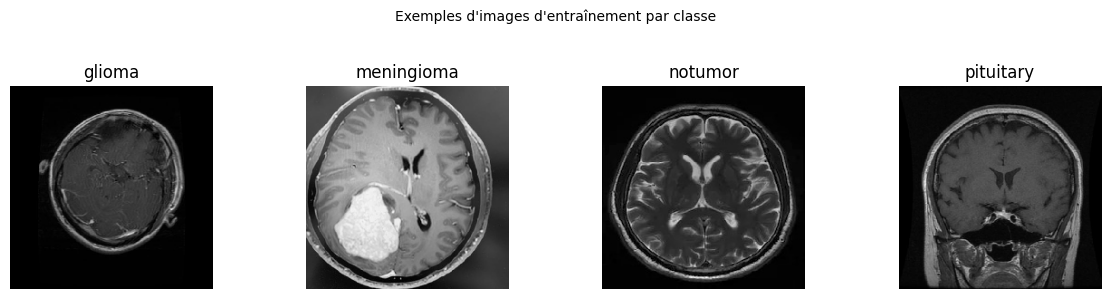

In [8]:
# Visualisation horizontale de 4 images d'entraînement (1 par classe)

samples_per_class = 1     # Nombre d'exemples à afficher par classe
num_classes = 4           # Nombre de classes à afficher
total_images = num_classes * samples_per_class

plt.figure(figsize=(total_images * 3, 3))  # Largeur ajustée à la quantité d'images

for idx, class_label in enumerate(class_labels[:num_classes]):

    # Trouver les chemins correspondant à la classe
    class_index = train_generator.class_indices[class_label]

    # Obtenir tous les chemins et classes depuis le générateur
    filepaths = train_generator.filepaths
    classes = train_generator.classes

    # Filtrer les indices correspondant à la classe actuelle
    indices = [i for i, c in enumerate(classes) if c == class_index]

    # Sélectionner les premiers exemples
    selected = indices[:samples_per_class]

    # Afficher les images sélectionnées
    for j, i in enumerate(selected):
        img_path = filepaths[i]
        img = load_img(img_path, target_size=IMG_SIZE)
        img_arr = img_to_array(img) / 255.0
        ax = plt.subplot(1, total_images, idx * samples_per_class + j + 1)  # 1 ligne, N colonnes
        ax.imshow(img_arr.astype('float32'))
        ax.set_title(f'{class_label}')
        ax.axis('off')

plt.suptitle("Exemples d'images d'entraînement par classe", fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


Visualisation de la distribution des classes dans l’ensemble d’entraînement

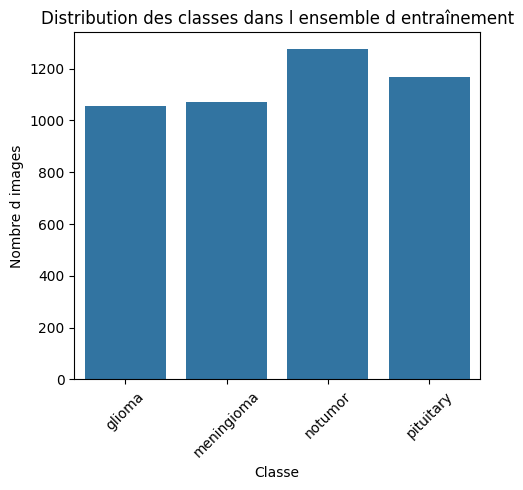

In [9]:
#Visualisation de la distribution des classes dans l'ensemble d'entraînement avec un countplot
class_labels = list(train_generator.class_indices.keys())
train_classes = train_generator.classes
plt.figure(figsize=(5, 5))
#Associe les classes à des étiquettes lisibles
sns.countplot(x=[class_labels[c] for c in train_classes])
plt.title('Distribution des classes dans l ensemble d entraînement')
plt.xlabel('Classe')
plt.ylabel('Nombre d images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Calcul des poids de classes pour équilibrer l’ensemble d’entraînement

In [10]:
#Calcul des poids de classe pour équilibrer les classes d'entraînement
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_classes),
    y=train_classes
)
class_weights_dict = {i: class_weights_vals[i] for i in range(len(class_weights_vals))}
print('Class weights:', class_weights_dict)

Class weights: {0: np.float64(1.0811258278145695), 1: np.float64(1.0659981343283582), 2: np.float64(0.8955721003134797), 3: np.float64(0.9800600343053173)}


Définition des callbacks et construction du modèle de transfert

In [11]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

#Fonction pour construire un modèle de transfert
def build_model(base_name, input_shape, num_classes, freeze_layers=True):

    #
    if base_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Base model {base_name} not supported")
    if freeze_layers:
        for layer in base_model.layers:
            layer.trainable = False

    #
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    #
    outputs = Dense(num_classes, activation='softmax')(x)

    #
    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

Entraînement des modèles VGG16 et ResNet50 et stockage des résultats





In [12]:
%%time

# Entraînement et stockage des résultats
results = {}
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
num_classes = len(class_labels)

for base_name in ['VGG16', 'ResNet50']:
    print(f"\nTreinando modelo com base {base_name}...")

    #
    model = build_model(base_name, input_shape, num_classes, freeze_layers=True)

    #
    history = model.fit(train_generator,
                        epochs=EPOCHS,
                        validation_data=validation_generator)

  #Évaluation sur l’ensemble de test
    test_loss, test_acc = model.evaluate(test_generator)
    print(f'{base_name} - Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}')

   # Prédictions sur l’ensemble de test
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes

    #Stocker tout dans results
    results[base_name] = {'model': model,
                          'history': history,
                          'predictions': predictions,
                          'predicted_classes': predicted_classes,
                          'true_classes': true_classes}


Treinando modelo com base VGG16...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 136s 848ms/step - accuracy: 0.7042 - loss: 0.7688 - val_accuracy: 0.6380 - val_loss: 1.0570
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 104s 670ms/step - accuracy: 0.8578 - loss: 0.4008 - val_accuracy: 0.7897 - val_loss: 0.7017
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 628ms/step - accuracy: 0.8738 - loss: 0.3363 - val_accuracy: 0.7888 - val_loss: 0.5644
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 99s 695ms/step - accuracy: 0.8825 - loss: 0.3127 - val_accuracy: 0.8221 - val_loss: 0.4931
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 567ms/step - accuracy: 0.8841 - loss: 0.2906 - val_accuracy: 0.8212 - val_loss: 0.4991
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 621ms/step - accuracy: 0.8953 - loss: 0.2689 - val_accuracy: 0.8195 - val_loss: 0.5309
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 592ms/step - accuracy: 0.9029 - loss: 0.2588 - val_accuracy: 0.8484 - val_loss: 0.4502
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 579ms/step - accuracy: 0.9096 - loss:

Visualisation des courbes d'entraînement (accuracy et loss) pour VGG16

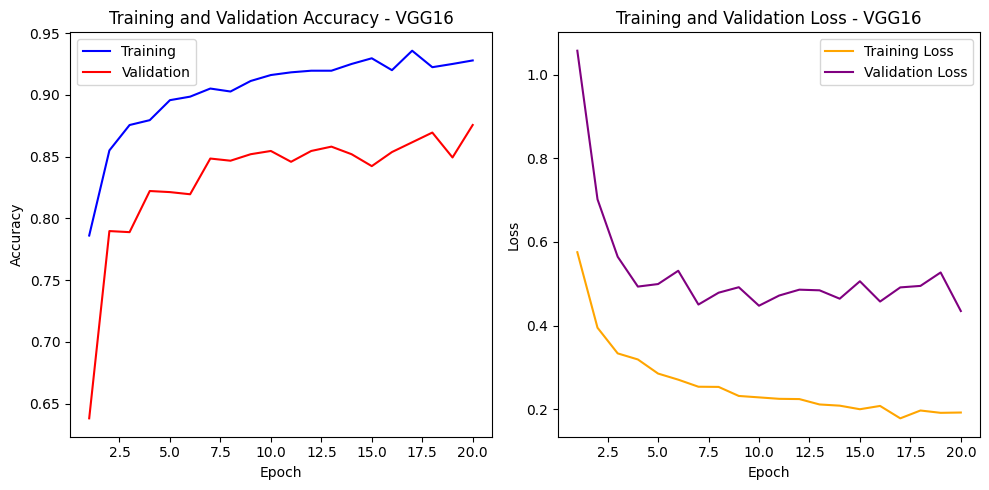

In [14]:
# 6. Tracé des courbes d'entraînement en sous-graphiques (précision et perte) avec des couleurs personnalisées
# Exemple pour VGG16

history = results['VGG16']['history']  # ou un autre modèle

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Précision : Entraînement en bleu, Validation en rouge
sns.lineplot(ax=axs[0], x=range(1, len(history.history['accuracy'])+1), y=history.history['accuracy'], label='Training', color='blue')
sns.lineplot(ax=axs[0], x=range(1, len(history.history['val_accuracy'])+1), y=history.history['val_accuracy'], label='Validation', color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy - VGG16')
axs[0].legend()

 # Perte : Entraînement en orange, Validation en violet
sns.lineplot(ax=axs[1], x=range(1, len(history.history['loss'])+1), y=history.history['loss'], label='Training Loss', color='orange')
sns.lineplot(ax=axs[1], x=range(1, len(history.history['val_loss'])+1), y=history.history['val_loss'], label='Validation Loss', color='purple')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss - VGG16')
axs[1].legend()
plt.tight_layout()

plt.show()

Visualisation des courbes d'entraînement (accuracy et loss) pour ResNet50

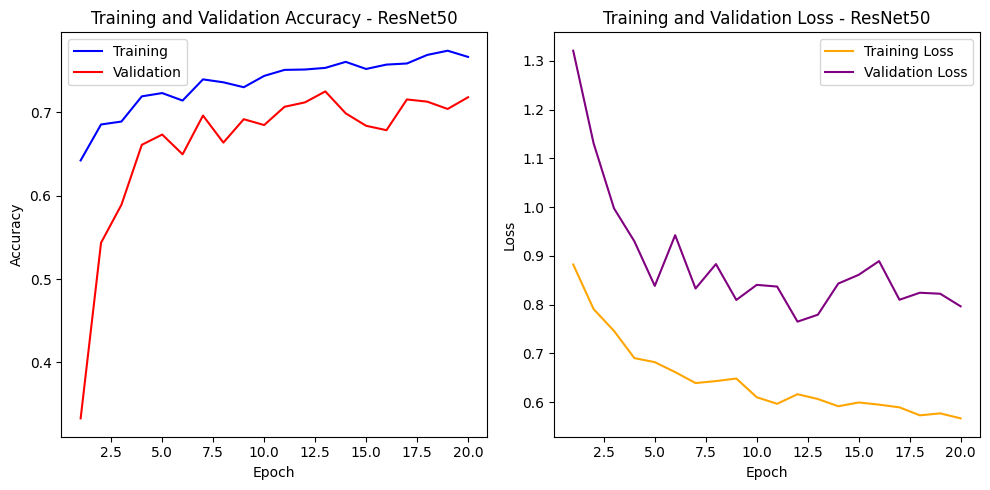

In [15]:
# 6. Tracé des courbes d'entraînement en sous-graphiques (précision et perte) avec des couleurs personnalisées
# Exemple pour ResNet50

history = results['ResNet50']['history']  # ou un autre modèle

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Précision : Entraînement en bleu, Validation en rouge
sns.lineplot(ax=axs[0], x=range(1, len(history.history['accuracy'])+1), y=history.history['accuracy'], label='Training', color='blue')
sns.lineplot(ax=axs[0], x=range(1, len(history.history['val_accuracy'])+1), y=history.history['val_accuracy'], label='Validation', color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy - ResNet50')
axs[0].legend()

 # Perte : Entraînement en orange, Validation en violet
sns.lineplot(ax=axs[1], x=range(1, len(history.history['loss'])+1), y=history.history['loss'], label='Training Loss', color='orange')
sns.lineplot(ax=axs[1], x=range(1, len(history.history['val_loss'])+1), y=history.history['val_loss'], label='Validation Loss', color='purple')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss - ResNet50')
axs[1].legend()
plt.tight_layout()

plt.show()

Matrices de confusion pour chaque modèle

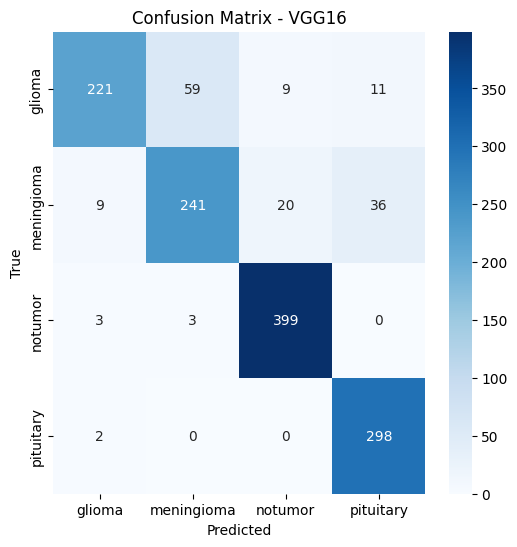

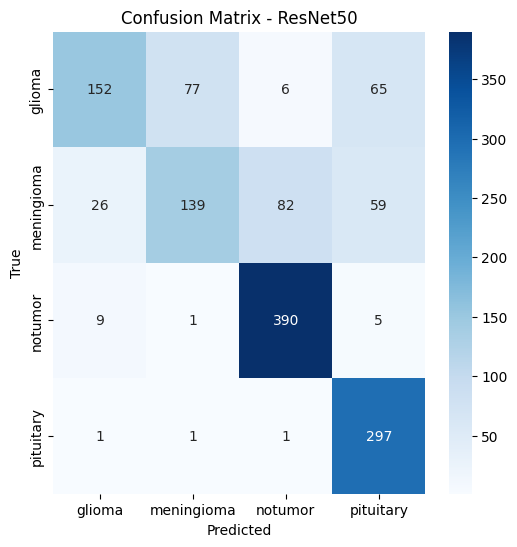

In [17]:
# Séparer les boucles pour différentes visualisations et rapports
# 1. Matrices de confusion
for base_name, res in results.items():
    cm = confusion_matrix(res['true_classes'], res['predicted_classes'])
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {base_name}')
    plt.show()

Rapport de classification pour chaque modèle

In [18]:
# 2. Classification Report
for base_name, res in results.items():
    print(f'Classification report - {base_name}:')
    report = classification_report(res['true_classes'], res['predicted_classes'], target_names=class_labels)
    print(report)

Classification report - VGG16:
              precision    recall  f1-score   support

      glioma       0.94      0.74      0.83       300
  meningioma       0.80      0.79      0.79       306
     notumor       0.93      0.99      0.96       405
   pituitary       0.86      0.99      0.92       300

    accuracy                           0.88      1311
   macro avg       0.88      0.88      0.87      1311
weighted avg       0.89      0.88      0.88      1311

Classification report - ResNet50:
              precision    recall  f1-score   support

      glioma       0.81      0.51      0.62       300
  meningioma       0.64      0.45      0.53       306
     notumor       0.81      0.96      0.88       405
   pituitary       0.70      0.99      0.82       300

    accuracy                           0.75      1311
   macro avg       0.74      0.73      0.71      1311
weighted avg       0.74      0.75      0.73      1311



Courbes ROC pour chaque modèle

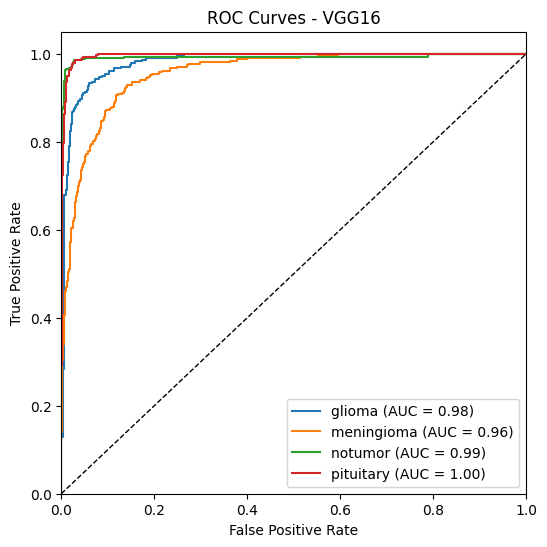

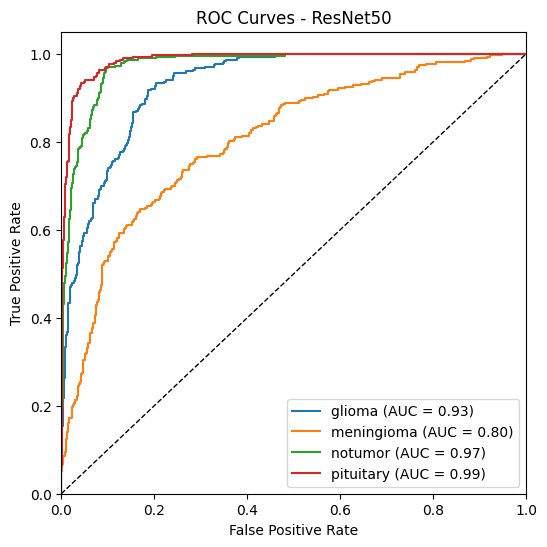

In [20]:
# 3. Courbes ROC
for base_name, res in results.items():
    y_true_bin = label_binarize(res['true_classes'], classes=list(range(num_classes)))
    y_score = res['predictions']
    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(6, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {base_name}')
    plt.legend(loc='lower right')
    plt.show()

Affichage de 4 exemples de prédictions par modèle avec une taille d’image réduite

Exemples de prédictions - VGG16


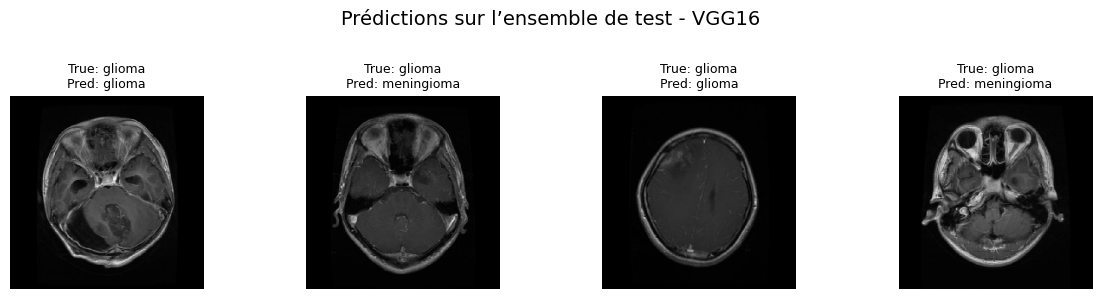

Exemples de prédictions - ResNet50


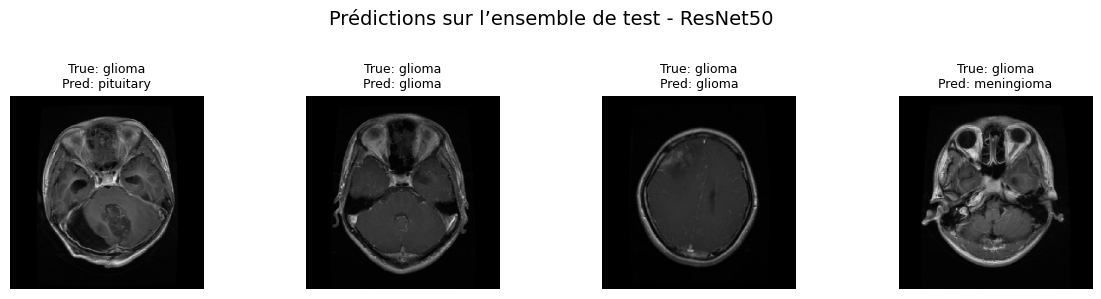

In [23]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 4. Prédictions en sous-graphiques (4 images par modèle, petite taille)
for base_name, res in results.items():
    print(f'Exemples de prédictions - {base_name}')

    num_images = 4  # nombre d’images à afficher
    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))  # 1 ligne, 4 colonnes
    axes = axes.flatten()

    for i in range(num_images):
        img_path = test_generator.filepaths[i]
        img = load_img(img_path, target_size=IMG_SIZE)
        img_arr = img_to_array(img) / 255.0

        true_label = res['true_classes'][i]
        pred_label = res['predicted_classes'][i]

        axes[i].imshow(img_arr.astype('float32'))
        axes[i].set_title(f'True: {class_labels[true_label]}\nPred: {class_labels[pred_label]}', fontsize=9)
        axes[i].axis('off')

    plt.suptitle(f'Prédictions sur l’ensemble de test - {base_name}', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()


Sauvegarde des modèles entraînés au format H5

In [22]:
from tensorflow.keras.models import load_model

# Répertoire de sauvegarde (optionnel : vous pouvez créer un dossier spécifique)
save_dir = "./models_sauvegardés"

import os
os.makedirs(save_dir, exist_ok=True)

# Parcours de tous les modèles stockés dans le dictionnaire results
for base_name, res in results.items():
    model = res['model']
    save_path = os.path.join(save_dir, f"modele_{base_name}.h5")

    # Sauvegarde
    model.save(save_path)
    print(f"Modèle {base_name} sauvegardé sous : {save_path}")


Modèle VGG16 sauvegardé sous : ./models_sauvegardés/modele_VGG16.h5
Modèle ResNet50 sauvegardé sous : ./models_sauvegardés/modele_ResNet50.h5
